In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('growth_rate.csv', index_col=0, header=[0] ,parse_dates=True)
dataset.head()

,CPIAUCSL,FEDFUNDS,HOUST,INDPRO,INTDSRUSM193N,ISRATIO,M2SL,MTSDS133FMS,PAYEMS,PCE,...,CIVPART,GS20,GS3,IRLTLT01USM156N,M1SL,MCOILWTICO,PPIACO,TCU,TOTALSA,PMI
1914-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.479339,NaN,NaN,NaN
1914-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.666667,NaN,NaN,NaN
1914-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.500000,NaN,NaN,NaN
1914-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.500000,NaN,NaN,NaN
1914-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-2.521008,NaN,NaN,NaN


In [3]:
CPI = dataset["CPIAUCSL"]
CPI.head()

1914-01-01   NaN
1914-02-01   NaN
1914-03-01   NaN
1914-04-01   NaN
1914-05-01   NaN
Name: CPIAUCSL, dtype: float64

In [4]:
y = CPI[CPI.notna()] # get rid of nan
y.shape

(853,)

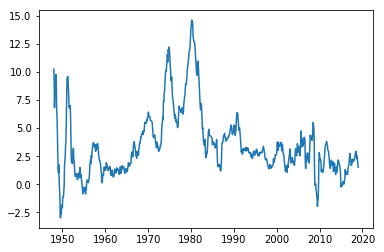

In [5]:
plt.plot(y)

In [6]:
t = y.shape[0]
x = np.concatenate((np.ones((t, 1)), 
                    y.shift(1).values.reshape((t, 1)),
                    y.shift(2).values.reshape((t, 1))), axis=1)
x.shape

(853, 3)

In [7]:
# Need to remove missing observations after lag
x = x[2:]
y = y[2:]
print(x.shape)
print(y.shape)

(851, 3)
(851,)


In [8]:
# convert to matrix
y = y.values.reshape((y.shape[0], 1))

In [9]:
# now set the priors, denoted by subscript 0
b_0 = np.zeros((3, 1))
sigma_0 = np.diag((1, 1, 1))

In [10]:
# priors for inverse gamma
t_0 = 1
d_0 = 0.1

In [11]:
# starting values for b and sigma squared (the values to be sampled)
b = b_0
var = 1

In [12]:
# iterations
reps = 5000
burn = 4000

In [13]:
from numpy.linalg import inv
from numpy.linalg import cholesky
from numpy.random import randn # draws from normal distribution
from numpy.linalg import eig
from math import sqrt

In [51]:
out_b = np.empty((3, 1))
out_var = np.empty((1,1))
out_forecasts = np.empty((y.shape[0] + 12, 1))

for i in range(reps):
    
    # params of the marginal condition distributions
    V = inv(inv(sigma_0) + (1/var) * np.matmul(x.transpose(), x))
    M = np.matmul(V,
                  np.matmul(inv(sigma_0), b_0) + (1/var) * np.matmul(x.transpose(), y))
    
    # sample from the conditional posterior for b
    while True:
        b = M + (np.matmul(np.random.randn(1, 3), cholesky(V))).transpose()
        comp = np.array([[b[1].item(), b[2].item()], [1, 0]])
        eigen, _ = eig(comp)
        max_eig = max(abs(eigen))
        if max_eig < 1: # is stable, then break
            break
    
    # sample from conditional posterior for var
    resids = y - np.matmul(x, b)
    # dof and scale for gamma:
    t_1 = t_0 + t
    d_1 = d_0 + np.matmul(resids.transpose(), resids)
    # draw from inverse gamma:
    z_0 = randn(t_1, 1)
    var = d_1/np.matmul(z_0.transpose(), z_0)
    
    # if retained draws
    if i > burn:
        out_b = np.concatenate((out_b, b), axis=1)
        out_var = np.concatenate((out_var, var), axis=1)
        
        # compute forecast for 2 years
        yhat = np.zeros((14, 1))
        yhat[0:2] = y[-2:] # starting values
        cfactor = sqrt(var); # standard deviation of the shocks
        
        for m in range(2, 14):
            yhat[m] = np.matmul(np.array([1, yhat[m-1].item(), yhat[m-2].item()]),
                                b) + randn(1, 1) * cfactor
            
        forecast = np.concatenate((y, yhat[2:]))    
        out_forecasts = np.concatenate((out_forecasts, forecast), axis=1)
        
        # to print progress
        if i % 100 == 0:
            print(str(i) + "/" + str(reps) + " done")
            
        
print(out_b.shape)
print(out_var.shape)
print(out_forecasts.shape)

4100/5000 done
4200/5000 done
4300/5000 done
4400/5000 done
4500/5000 done
4600/5000 done
4700/5000 done
4800/5000 done
4900/5000 done
(3, 1000)
(1, 1000)
(863, 1000)


In [52]:
from utils import is_outlier

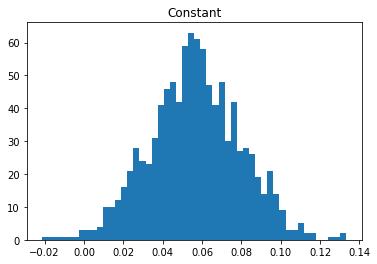

In [53]:
fig, ax = plt.subplots()
ax.hist(out_b[0][~is_outlier(out_b[0])], bins=50)
ax.set_title("Constant")
plt.show()

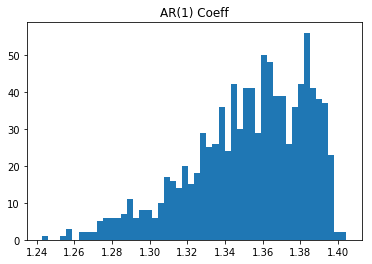

In [54]:
plt.hist(out_b[1][~is_outlier(out_b[1])], bins=50)
plt.title("AR(1) Coeff")
plt.show()

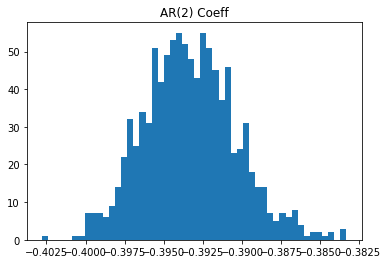

In [55]:
plt.hist(out_b[2][~is_outlier(out_b[2])], bins=50)
plt.title("AR(2) Coeff")
plt.show()

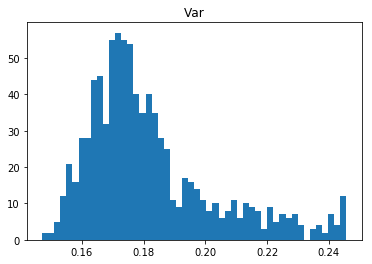

In [56]:
plt.hist(out_var[0][~is_outlier(out_var[0])], bins=50)
plt.title("Var")
plt.show()

In [57]:
# the incredible thing is, these values are very similar to the BOE guide

In [58]:
out_x = np.percentile(out_forecasts, [10, 20, 30, 40, 50, 60, 70, 80, 90], axis=1)
out_x.shape

(9, 863)

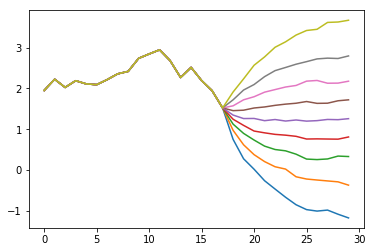

In [59]:
plt.plot(out_x.transpose()[-30:])

In [ ]:
# sick